In [3]:
# First stage of processing. Create WSA out of CLARA-A2 BSA, prefilter, reproject all data to EASE2
# All computations made for both hemispheres, so this code is resource-heavy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyresample
import dask.array as da
import pandas as pd
import glob

datadriveletter = 'Z:'
CLARA_datadir = 'F:/CLARA-A2-SAL-complete/mm/'
width_h = height_h = 720

## Load CLARA-A2 BSA, create WSA estimates and combine

In [7]:
#begin with the global CLARA record as the polar subsets unfortunately do not cover the Arctic or Antarctic quite fully
CLARAs = xr.open_mfdataset(CLARA_datadir + '*.nc')

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


For simplicity, no prefiltering of the albedo data at this stage. Also, the vegetation/snow/snowy forest albedo estimates are calculated everywhere and combined with appropriate land cover data later. This is inefficient computationally but yields flexibility in later data selection when everything is available everywhere.

In [8]:
#reproject to EASE2
from pyproj import Proj
try:
    # Works with pyproj 2.0+
    PROJECTION_NH = Proj('EPSG:6931')
    PROJECTION_SH = Proj('EPSG:6932')
except RuntimeError:
    # Works with pyproj 1.x
    PROJECTION_NH = Proj('+init=EPSG:6931')
    PROJECTION_SH = Proj('+init=EPSG:6932')
    
# Create output grid coordinates in projection units (meters)
RESOLUTION = 25000.
WIDTH = 720
HEIGHT = 720
X_VECT = np.arange(-RESOLUTION * WIDTH / 2. + RESOLUTION / 2.,
                   RESOLUTION * WIDTH / 2., RESOLUTION)
# Orient so that 0-meridian is pointing down
Y_VECT = np.arange(RESOLUTION * WIDTH / 2. - RESOLUTION / 2.,
                   -RESOLUTION * WIDTH / 2., -RESOLUTION)
TARGET_X, TARGET_Y = np.meshgrid(X_VECT, Y_VECT)
EASE2Nlon, EASE2Nlat = PROJECTION_NH(TARGET_X, TARGET_Y, inverse=True)
EASE2Slon, EASE2Slat = PROJECTION_SH(TARGET_X, TARGET_Y, inverse=True)

CLARAlon, CLARAlat = np.meshgrid(CLARAs.lon.values, CLARAs.lat.values)

#AntarcticSIlon, AntarcticSIlat = (Antarctic_SIs.longitude.values, Antarctic_SIs.latitude.values)
CLARA_swath = pyresample.geometry.SwathDefinition(lats=np.squeeze(CLARAlat), lons=CLARAlon)
EASE2N_swath = pyresample.geometry.SwathDefinition(lats=EASE2Nlat, lons=EASE2Nlon)
EASE2S_swath = pyresample.geometry.SwathDefinition(lats=EASE2Slat, lons=EASE2Slon)

(valid_input_index_NH, valid_output_index_NH, \
 index_array_NH, distance_array_NH) = pyresample.kd_tree.get_neighbour_info(CLARA_swath, EASE2N_swath, \
                                                                      radius_of_influence=35000, \
                                                                      neighbours=1, nprocs=8)
(valid_input_index_SH, valid_output_index_SH, \
 index_array_SH, distance_array_SH) = pyresample.kd_tree.get_neighbour_info(CLARA_swath, EASE2S_swath, \
                                                                      radius_of_influence=35000, \
                                                                      neighbours=1, nprocs=8)

In [10]:
#calculate vegetation WSA (Yang et al.)

wsa_veg = CLARAs['sal']/100. *  (1 + 1.48 * np.cos(np.deg2rad(CLARAs['SZA'])))/ 2.14

#calculate snow WSA (Manninen et al., 2019)
wsa_snow = (CLARAs['sal']/100. * (1 + np.deg2rad(CLARAs['SZA']) * (1.003 + 0.128*np.deg2rad(CLARAs['SZA']) - 1.39*CLARAs['sal']/100. + \
                                               0.0341 * CLARAs['sal_median']/100. - 0.998 * CLARAs['sal_std']/100. - \
                                               0.0155 * CLARAs['sal_skewness'] - 0.000625 * CLARAs['sal_kurtosis']) )).compute()

#calculate snowy forest WSA (Manninen et al., 2019) - will eventually be applied to a small number of grid cells
wsa_snowforest = (CLARAs['sal']/100. * (1 + np.deg2rad(CLARAs['SZA']) * (-0.592 + 0.709*np.deg2rad(CLARAs['SZA']) - \
                                                               11.4*CLARAs['sal']/100. + \
                                                               11.0 * CLARAs['sal_median']/100. + \
                                                               5.10 * CLARAs['sal_std']/100. + \
                                                               0.0204 * CLARAs['sal_skewness'] - \
                                                               0.0205 * CLARAs['sal_kurtosis']) )).compute()
wsa_snowforest *= np.exp(0.1 * (wsa_snowforest**4))

In [30]:
#get nobs first
from dask.diagnostics import ProgressBar
from tqdm.notebook import trange, tqdm

res_NH = []
res_SH = []
width_h = height_h = 720
for i in tqdm(range(len(CLARAs.time.values))):
    res_NH.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_h,height_h), \
                                                                CLARAs['nobs_sal'].values[i,:,:], \
                                                                 valid_input_index_NH, \
                                                                 valid_output_index_NH, index_array_NH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    res_SH.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_h,height_h), \
                                                                CLARAs['nobs_sal'].values[i,:,:], \
                                                                 valid_input_index_SH, \
                                                                 valid_output_index_SH, index_array_SH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    
with ProgressBar():
    res_NH = da.stack(res_NH).compute()
    res_SH = da.stack(res_SH).compute()

SAL_NOBS_NH_xr = xr.DataArray(data=res_NH, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':pd.to_datetime(CLARAs.time.values)})
SAL_NOBS_SH_xr = xr.DataArray(data=res_SH, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':pd.to_datetime(CLARAs.time.values)})


[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s


In [37]:
SAL_NOBS_NH_xr.to_netcdf(datadriveletter + '/radiative_forcing_2020/production_data/SAL_NOBS_NH_full_extended.nc')
SAL_NOBS_SH_xr.to_netcdf(datadriveletter + '/radiative_forcing_2020/production_data/SAL_NOBS_SH_full_extended.nc')

In [38]:
#WSA estimates / vegetation
#reusing result list names
res_NH = []
res_SH = []
width_h = height_h = 720
for i in tqdm(range(len(CLARAs.time.values))):
    res_NH.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_h,height_h), \
                                                                wsa_veg.values[i,:,:], \
                                                                 valid_input_index_NH, \
                                                                 valid_output_index_NH, index_array_NH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    res_SH.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_h,height_h), \
                                                                wsa_veg.values[i,:,:], \
                                                                 valid_input_index_SH, \
                                                                 valid_output_index_SH, index_array_SH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    
with ProgressBar():
    res_NH = da.stack(res_NH).compute()
    res_SH = da.stack(res_SH).compute()

WSA_VEG_NH_xr = xr.DataArray(data=res_NH, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':pd.to_datetime(CLARAs.time.values)})
WSA_VEG_SH_xr = xr.DataArray(data=res_SH, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':pd.to_datetime(CLARAs.time.values)})


[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s


In [39]:
WSA_VEG_NH_xr.to_netcdf(datadriveletter + '/radiative_forcing_2020/production_data/WSA_VEG_NH_full_extended.nc')
WSA_VEG_SH_xr.to_netcdf(datadriveletter + '/radiative_forcing_2020/production_data/WSA_VEG_SH_full_extended.nc')

In [40]:
#WSA estimates / snow
res_NH = []
res_SH = []
width_h = height_h = 720
for i in tqdm(range(len(CLARAs.time.values))):
    res_NH.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_h,height_h), \
                                                                wsa_snow.values[i,:,:], \
                                                                 valid_input_index_NH, \
                                                                 valid_output_index_NH, index_array_NH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    res_SH.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_h,height_h), \
                                                                wsa_snow.values[i,:,:], \
                                                                 valid_input_index_SH, \
                                                                 valid_output_index_SH, index_array_SH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    
with ProgressBar():
    res_NH = da.stack(res_NH).compute()
    res_SH = da.stack(res_SH).compute()

WSA_SNOW_NH_xr = xr.DataArray(data=res_NH, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':pd.to_datetime(CLARAs.time.values)})
WSA_SNOW_SH_xr = xr.DataArray(data=res_SH, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':pd.to_datetime(CLARAs.time.values)})


[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s


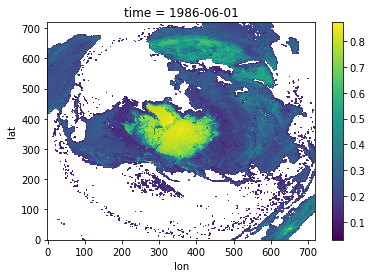

In [44]:
WSA_SNOW_NH_xr[53,:,:].plot()

In [45]:
WSA_SNOW_NH_xr.to_netcdf(datadriveletter + '/radiative_forcing_2020/production_data/WSA_SNOW_NH_full_extended.nc')
WSA_SNOW_SH_xr.to_netcdf(datadriveletter + '/radiative_forcing_2020/production_data/WSA_SNOW_SH_full_extended.nc')

In [46]:
#WSA estimates / snowy forest
res_NH = []
res_SH = []
width_h = height_h = 720
for i in tqdm(range(len(CLARAs.time.values))):
    res_NH.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_h,height_h), \
                                                                wsa_snowforest.values[i,:,:], \
                                                                 valid_input_index_NH, \
                                                                 valid_output_index_NH, index_array_NH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    res_SH.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_h,height_h), \
                                                                wsa_snowforest.values[i,:,:], \
                                                                 valid_input_index_SH, \
                                                                 valid_output_index_SH, index_array_SH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    
with ProgressBar():
    res_NH = da.stack(res_NH).compute()
    res_SH = da.stack(res_SH).compute()

WSA_SNOWFOREST_NH_xr = xr.DataArray(data=res_NH, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':pd.to_datetime(CLARAs.time.values)})
WSA_SNOWFOREST_SH_xr = xr.DataArray(data=res_SH, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':pd.to_datetime(CLARAs.time.values)})


[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s


In [47]:
WSA_SNOWFOREST_NH_xr.to_netcdf(datadriveletter + '/radiative_forcing_2020/production_data/WSA_SNOWFOREST_NH_full_extended.nc')
WSA_SNOWFOREST_SH_xr.to_netcdf(datadriveletter + '/radiative_forcing_2020/production_data/WSA_SNOWFOREST_SH_full_extended.nc')

In [ ]:
# Next we need NH forest cover data plus snow/ice coverage for NH and SH.
# Arctic/Antarctic SIC from G02202 -> reprojected into CLARA EASE2. See /Antarctic_Arctic_seaice_to_EASE2.ipynb
# Gap-filled missing months in Antarctic coverage, otherwise direct reprojection is enough.

#snow/ice cover 

In [ ]:
from tqdm import tqdm_notebook
from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress
import dask
from datetime import datetime
import dask.multiprocessing
dask.config.set(scheduler='processes')

#client = Client(threads_per_worker=1, n_workers=4)


def get_forest_fraction(data, windowsize):
    return len(np.where((data==50) | (data==60) | (data==70) | (data==80) | (data==90))[0]) / (windowsize*windowsize)
    #return len([x for x in np.nditer(data) if x in forests]) / (windowsize*windowsize)


forests = [50,60,70,80,90]

windowsize = np.int(85)
#with Client(threads_per_worker=1, n_workers=4) as client:
with dask.config.set(num_workers=4):
    for yr in np.arange(2016,2019):
        timestart = datetime.utcnow()
        print(yr, timestart)
        res = []

        if yr>2015:
            ESACCI = xr.open_dataset(CCILUCdir + 'C3S-LC-L4-LCCS-Map-300m-P1Y-'+str(yr)+'-v2.1.1.nc')
        else:
            ESACCI = xr.open_dataset(CCILUCdir + 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-'+str(yr)+'-v2.0.7b.nc')
        startys = np.arange(0,len(ESACCI['lat'])/2,windowsize)
        startxs = np.arange(0,len(ESACCI['lon']),windowsize)
        #resampled_luc = np.zeros((len(startys), len(startxs)))*np.nan
        print('To process (rows,cols)')
        print(len(startys), len(startxs))
        ESACCI_lucdata = ESACCI['lccs_class'].squeeze()
        for starty in tqdm_notebook(startys):
            for startx in startxs:
                starty = np.int(starty)
                startx = np.int(startx)
                lazy_res = dask.delayed(get_forest_fraction)(ESACCI_lucdata[starty:starty+windowsize,startx:startx+windowsize], windowsize)
                res.append(lazy_res)
        print(datetime.utcnow()-timestart,' - Computing...')
        with ProgressBar():

            results=dask.compute(*res)
        #futures = dask.persist(*res)
        #progress(futures)
        #results = dask.compute(*futures)

        resampled_luc = np.array(results).reshape((len(startys), len(startxs)))

        #resampled_luc = np.zeros((len(startys), len(startxs)))*np.nan
        #resampled_lat = np.zeros((len(startys), len(startxs)))*np.nan
        #resampled_lon = np.zeros((len(startys), len(startxs)))*np.nan
        #for i,starty in tqdm_notebook(enumerate(startys)):
        #    for j,startx in enumerate(startxs):
        #        starty = np.int(starty)
        #        startx = np.int(startx)
        #        luc_chunk = ESACCI['lccs_class'][starty:starty+windowsize,startx:startx+windowsize]
        #        resampled_luc[i,j] = len([x for x in np.nditer(luc_chunk) if x in forests]) / (windowsize*windowsize)
        #        resampled_lat[i,j] = ESACCI['lat'][starty:starty+windowsize].mean()
        #        resampled_lon[i,j] = ESACCI['lon'][startx:startx+windowsize].mean()

        print(datetime.utcnow()-timestart,' - Saving...')


        foo = xr.Dataset({'forestcover':(('lat','lon'),resampled_luc)} )
        #foo['latitude'] = (('lat','lon'),resampled_lat)
        #foo['longitude'] = (('lat','lon'),resampled_lon)
        foo['time'] = pd.to_datetime(str(yr)+'-01-01')
        foo.to_netcdf('Z:/LUC_CCI/annual/CCI_forestcover_'+str(yr)+'.nc')
    #client.close()

In [4]:
#load, assign lat/lon
forestcover = xr.open_mfdataset(datadriveletter + '/LUC_CCI/annual/CCI_forestcover_*.nc', concat_dim='time')

windowsize = 85
CCILUCdir = datadriveletter + '/LUC_CCI/'

ESACCI = xr.open_dataset(CCILUCdir + 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-'+str(2014)+'-v2.0.7b.nc')
startys = np.arange(0,len(ESACCI['lat'])/2,windowsize)
startxs = np.arange(0,len(ESACCI['lon']),windowsize)

CCI_rs_lats_half = ESACCI['lat'][0:np.int(len(ESACCI['lat'])/2)]
CCI_rs_lons = ESACCI['lon'][0:np.int(len(ESACCI['lon']))]

meanlats = []
meanlons = []

for i in np.arange(0,len(CCI_rs_lats_half), 85):
    cutlat = CCI_rs_lats_half[i:i+85]
    meanlats.append(np.nanmean(cutlat))

meanlats = np.array(meanlats)
print(meanlats.shape)

for i in np.arange(0,len(CCI_rs_lons), 85):
    cutlon = CCI_rs_lons[i:i+85]
    meanlons.append(np.nanmean(cutlon))

meanlons = np.array(meanlons)
print(meanlons.shape)

CCI_resampled_lon, CCI_resampled_lat = np.meshgrid(meanlons, meanlats)
forestcover = forestcover.assign_coords({'latitude':(('lat','lon'),CCI_resampled_lat)})
forestcover = forestcover.assign_coords({'longitude':(('lat','lon'),CCI_resampled_lon)})

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\backends\api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


(382,)
(1525,)


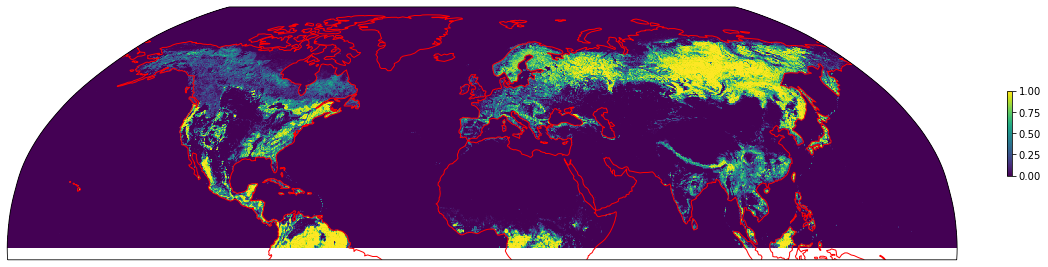

In [16]:
#check if OK
visprj = ccrs.Robinson()
plt.figure(figsize=(18,12))
ax = plt.axes(projection=visprj)
plt.pcolormesh(forestcover.longitude, forestcover.latitude, forestcover.forestcover.sel(time='2015-01-01'),\
              transform=ccrs.PlateCarree())
plt.colorbar(fraction=0.0042)
ax.coastlines(color='red')
plt.show()

In [32]:
CCIswath = pyresample.geometry.SwathDefinition(lats=forestcover.latitude.values,\
                                              lons=forestcover.longitude.values)
#reproject to EASE2
from pyproj import Proj
try:
    # Works with pyproj 2.0+
    PROJECTION_NH = Proj('EPSG:6931')
    PROJECTION_SH = Proj('EPSG:6932')
except RuntimeError:
    # Works with pyproj 1.x
    PROJECTION_NH = Proj('+init=EPSG:6931')
    PROJECTION_SH = Proj('+init=EPSG:6932')
    
# Create output grid coordinates in projection units (meters)
RESOLUTION = 25000.
WIDTH = 720
HEIGHT = 720
X_VECT = np.arange(-RESOLUTION * WIDTH / 2. + RESOLUTION / 2.,
                   RESOLUTION * WIDTH / 2., RESOLUTION)
# Orient so that 0-meridian is pointing down
Y_VECT = np.arange(RESOLUTION * WIDTH / 2. - RESOLUTION / 2.,
                   -RESOLUTION * WIDTH / 2., -RESOLUTION)
TARGET_X, TARGET_Y = np.meshgrid(X_VECT, Y_VECT)
EASE2Nlon, EASE2Nlat = PROJECTION_NH(TARGET_X, TARGET_Y, inverse=True)
EASE2Slon, EASE2Slat = PROJECTION_SH(TARGET_X, TARGET_Y, inverse=True)

EASE2Nswath = pyresample.geometry.SwathDefinition(lats=EASE2Nlat,\
                                              lons=EASE2Nlon)

CCI_at_EASE2 = np.zeros((len(forestcover.time), len(EASE2Nlat), len(EASE2Nlon))) * np.nan
for i in np.arange(0,len(forestcover.time)):
    CCI_at_EASE2[i,:,:] = pyresample.kd_tree.resample_nearest(CCIswath, forestcover.forestcover[i,:,:].values,\
                                                  EASE2Nswath, radius_of_influence=30000, fill_value=np.nan)

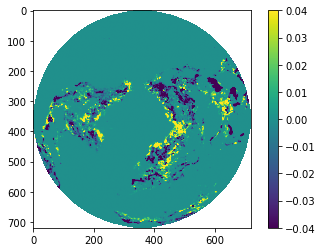

In [13]:
plt.imshow(CCI_at_EASE2[-4,:,:]-CCI_at_EASE2[0,:,:], vmin=-0.04, vmax=0.04)
plt.colorbar()

In [18]:
CCI_EASE2 = xr.DataArray(CCI_at_EASE2, dims=('time','lat','lon'))
CCI_EASE2['time']=forestcover.time

monthlies = pd.date_range('1992-01-01', '2018-12-01', freq='MS')
print(monthlies)

CCI_EASE2 = CCI_EASE2.reindex({'time':monthlies}, method='ffill')
CCI_EASE2

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', length=324, freq='MS')


<xarray.DataArray (time: 324, lat: 720, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2018-12-01
Dimensions without coordinates: lat, lon

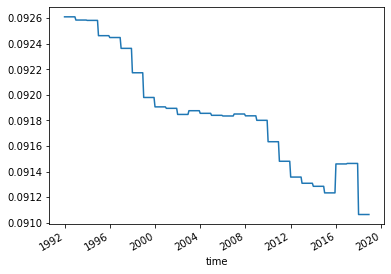

In [19]:
CCI_EASE2.mean(('lat', 'lon')).plot()

In [20]:
CCI_EASE2.to_netcdf(datadriveletter + '/EASE2_reprojected/forestcover_MM_EASE2_1992_2018_ESACCI.nc')

In [12]:
# Finally, extract and reproject CC and CACK kernels into CLARA/EASE2 projection
CACK = xr.open_dataset(datadriveletter+'/radiative_kernels/CACK/CACKv1.0.nc')
print(CACK)
CACKlon, CACKlat = np.meshgrid(CACK['Longitude'].values, CACK['Latitude'].values)
CACKlon = pyresample.utils.wrap_longitudes(CACKlon)

#optional, use coordinates from already-reprojected CC kernel
#CSkern = xr.open_dataset(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CS_CALIPSO.nc')
#NSIDClat = CSkern['latitude'].values #= np.reshape(np.fromfile('/mnt/ariihela/NSIDC_0046/EASE2_N25km.lats.720x720x1.double', dtype=np.float64), (720,720))
#NSIDClon = CSkern['longitude'].values #= np.reshape(np.fromfile('/mnt/ariihela/NSIDC_0046/EASE2_N25km.lons.720x720x1.double', dtype=np.float64), (720,720))

# or use EASE2Nlat and EASE2Nlon calculated earlier (default)


CACK_swath = pyresample.geometry.SwathDefinition(lats=CACKlat, lons=CACKlon)
EASE2N_swath = pyresample.geometry.SwathDefinition(lats=EASE2Nlat, lons=EASE2Nlon)
EASE2S_swath = pyresample.geometry.SwathDefinition(lats=EASE2Slat, lons=EASE2Slon)

(EASE2N_valid_input_index, EASE2N_valid_output_index, \
 EASE2N_index_array, EASE2N_distance_array) = pyresample.kd_tree.get_neighbour_info(CACK_swath, EASE2N_swath, \
                                                                      radius_of_influence=130000, \
                                                                      neighbours=1, nprocs=8)
(EASE2S_valid_input_index, EASE2S_valid_output_index, \
 EASE2S_index_array, EASE2S_distance_array) = pyresample.kd_tree.get_neighbour_info(CACK_swath, EASE2S_swath, \
                                                                      radius_of_influence=130000, \
                                                                      neighbours=1, nprocs=8)


<xarray.Dataset>
Dimensions:         (Month: 12, Year: 16, col: 360, row: 180)
Coordinates:
  * Month           (Month) float32 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
  * Year            (Year) float32 1.0 2.0 3.0 4.0 5.0 ... 13.0 14.0 15.0 16.0
Dimensions without coordinates: col, row
Data variables:
    Latitude        (row) float32 ...
    Longitude       (col) float32 ...
    CACK            (Year, Month, col, row) float32 ...
    Sigma_total     (Year, Month, col, row) float32 ...
    Sigma_me        (Year, Month, col, row) float32 ...
    Sigma_du        (Year, Month, col, row) float32 ...
    CACK CM         (Month, col, row) float32 ...
    Sigma_total CM  (Month, col, row) float32 ...
    Sigma_me CM     (Month, col, row) float32 ...
    Sigma_du_pv CM  (Month, col, row) float32 ...
Attributes:
    creation_date:   20-Jun-2019 19:44:42
    Latitude:        degrees north-to-south
    Longitude:       degrees west-to-east
    Month:           month number
    Year:          

In [13]:
import gc
res = []
dts = []
width_nh = height_nh = 720
print('***CACK->EASE2, NH***')

for yr in CACK['Year'].values.astype(np.int):#len(GLASS_MM_sunlit.time.values)):
    for mn in CACK['Month'].values.astype(np.int):
        tstamp = pd.to_datetime(str(int(yr+2000))+'-'+str(int(mn)), format='%Y-%m')
        dts.append(tstamp)
        print(tstamp)
        thiskern = CACK['CACK'].values[yr-1,mn-1,:,:].T
        res.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_nh,height_nh), \
                                                                    thiskern, EASE2N_valid_input_index, \
                                                                     EASE2N_valid_output_index, EASE2N_index_array, \
                                                                     weight_funcs=None, \
                                                                     fill_value=np.nan, with_uncert=False))
        gc.collect()
res = da.stack(res).compute()
CACK_EASE2N_xr = xr.DataArray(data=res, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':pd.to_datetime(dts)})

res = []
dts = []
width_sh = height_sh = 720
print('***CACK->EASE2, SH***')

for yr in CACK['Year'].values.astype(np.int):#len(GLASS_MM_sunlit.time.values)):
    for mn in CACK['Month'].values.astype(np.int):
        tstamp = pd.to_datetime(str(int(yr+2000))+'-'+str(int(mn)), format='%Y-%m')
        dts.append(tstamp)
        print(tstamp)
        thiskern = CACK['CACK'].values[yr-1,mn-1,:,:].T
        res.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_sh,height_sh), \
                                                                    thiskern, EASE2S_valid_input_index, \
                                                                     EASE2S_valid_output_index, EASE2S_index_array, \
                                                                     weight_funcs=None, \
                                                                     fill_value=np.nan, with_uncert=False))
        gc.collect()
res = da.stack(res).compute()
CACK_EASE2S_xr = xr.DataArray(data=res, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':pd.to_datetime(dts)})

***CACK->EASE2, NH***
2001-01-01 00:00:00
2001-02-01 00:00:00
2001-03-01 00:00:00
2001-04-01 00:00:00
2001-05-01 00:00:00
2001-06-01 00:00:00
2001-07-01 00:00:00
2001-08-01 00:00:00
2001-09-01 00:00:00
2001-10-01 00:00:00
2001-11-01 00:00:00
2001-12-01 00:00:00
2002-01-01 00:00:00
2002-02-01 00:00:00
2002-03-01 00:00:00
2002-04-01 00:00:00
2002-05-01 00:00:00
2002-06-01 00:00:00
2002-07-01 00:00:00
2002-08-01 00:00:00
2002-09-01 00:00:00
2002-10-01 00:00:00
2002-11-01 00:00:00
2002-12-01 00:00:00
2003-01-01 00:00:00
2003-02-01 00:00:00
2003-03-01 00:00:00
2003-04-01 00:00:00
2003-05-01 00:00:00
2003-06-01 00:00:00
2003-07-01 00:00:00
2003-08-01 00:00:00
2003-09-01 00:00:00
2003-10-01 00:00:00
2003-11-01 00:00:00
2003-12-01 00:00:00
2004-01-01 00:00:00
2004-02-01 00:00:00
2004-03-01 00:00:00
2004-04-01 00:00:00
2004-05-01 00:00:00
2004-06-01 00:00:00
2004-07-01 00:00:00
2004-08-01 00:00:00
2004-09-01 00:00:00
2004-10-01 00:00:00
2004-11-01 00:00:00
2004-12-01 00:00:00
2005-01-01 00:00:0

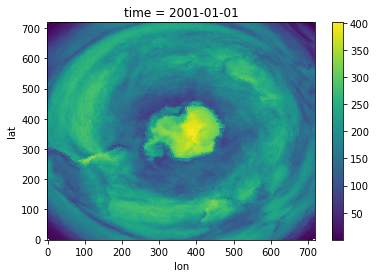

In [14]:
CACK_EASE2S_xr[0,:,:].plot()

In [15]:
#reproject the new and improved uncertainty estimate (sigma-me) as provided by Ryan B.
import gc

CACK_new_sigma_me = xr.open_dataarray(datadriveletter+'/radiative_kernels/CACK/Sigma_me_v2.nc')
sigma_du = CACK['Sigma_du']
new_sigma_total = sigma_du + CACK_new_sigma_me
print('***CACK->EASE2, NH***')
res = []
dts = []
width_nh = height_nh = 720
for yr in CACK['Year'].values.astype(np.int):#len(GLASS_MM_sunlit.time.values)):
    for mn in CACK['Month'].values.astype(np.int):
        tstamp = pd.to_datetime(str(int(yr+2000))+'-'+str(int(mn)), format='%Y-%m')
        dts.append(tstamp)
        print(tstamp)
        thiskern = new_sigma_total.values[yr-1,mn-1,:,:].T
        res.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_nh,height_nh), \
                                                                    thiskern, EASE2N_valid_input_index, \
                                                                     EASE2N_valid_output_index, EASE2N_index_array, \
                                                                     weight_funcs=None, \
                                                                     fill_value=np.nan, with_uncert=False))
        gc.collect()
res = da.stack(res).compute()
CACK_UNCERT_EASE2N_xr = xr.DataArray(data=res, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':pd.to_datetime(dts)})
print('***CACK->EASE2, SH***')
res = []
dts = []
width_sh = height_sh = 720
for yr in CACK['Year'].values.astype(np.int):#len(GLASS_MM_sunlit.time.values)):
    for mn in CACK['Month'].values.astype(np.int):
        tstamp = pd.to_datetime(str(int(yr+2000))+'-'+str(int(mn)), format='%Y-%m')
        dts.append(tstamp)
        print(tstamp)
        thiskern = new_sigma_total.values[yr-1,mn-1,:,:].T
        res.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_sh,height_sh), \
                                                                    thiskern, EASE2S_valid_input_index, \
                                                                     EASE2S_valid_output_index, EASE2S_index_array, \
                                                                     weight_funcs=None, \
                                                                     fill_value=np.nan, with_uncert=False))
        gc.collect()
res = da.stack(res).compute()
CACK_UNCERT_EASE2S_xr = xr.DataArray(data=res, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':pd.to_datetime(dts)})

***CACK->EASE2, NH***
2001-01-01 00:00:00
2001-02-01 00:00:00
2001-03-01 00:00:00
2001-04-01 00:00:00
2001-05-01 00:00:00
2001-06-01 00:00:00
2001-07-01 00:00:00
2001-08-01 00:00:00
2001-09-01 00:00:00
2001-10-01 00:00:00
2001-11-01 00:00:00
2001-12-01 00:00:00
2002-01-01 00:00:00
2002-02-01 00:00:00
2002-03-01 00:00:00
2002-04-01 00:00:00
2002-05-01 00:00:00
2002-06-01 00:00:00
2002-07-01 00:00:00
2002-08-01 00:00:00
2002-09-01 00:00:00
2002-10-01 00:00:00
2002-11-01 00:00:00
2002-12-01 00:00:00
2003-01-01 00:00:00
2003-02-01 00:00:00
2003-03-01 00:00:00
2003-04-01 00:00:00
2003-05-01 00:00:00
2003-06-01 00:00:00
2003-07-01 00:00:00
2003-08-01 00:00:00
2003-09-01 00:00:00
2003-10-01 00:00:00
2003-11-01 00:00:00
2003-12-01 00:00:00
2004-01-01 00:00:00
2004-02-01 00:00:00
2004-03-01 00:00:00
2004-04-01 00:00:00
2004-05-01 00:00:00
2004-06-01 00:00:00
2004-07-01 00:00:00
2004-08-01 00:00:00
2004-09-01 00:00:00
2004-10-01 00:00:00
2004-11-01 00:00:00
2004-12-01 00:00:00
2005-01-01 00:00:0

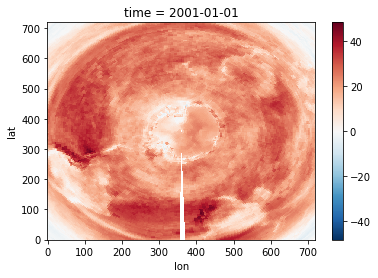

In [16]:
CACK_UNCERT_EASE2S_xr[0,:,:].plot()

In [17]:
#bfill and ffill into full extended-A2 coverage period
A2_period = pd.date_range('01-01-1982', '12-01-2018', freq='MS')
print(A2_period)
foo = np.zeros((len(A2_period), width_h,height_h))*np.nan
CACK_EASE2N_full_xr = xr.DataArray(data=foo.copy(), dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':pd.to_datetime(A2_period)})
CACK_UNCERT_EASE2N_full_xr = xr.DataArray(data=foo.copy(), dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':pd.to_datetime(A2_period)})

CACK_EASE2S_full_xr = xr.DataArray(data=foo.copy(), dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':pd.to_datetime(A2_period)})
CACK_UNCERT_EASE2S_full_xr = xr.DataArray(data=foo.copy(), dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':pd.to_datetime(A2_period)})

DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', length=444, freq='MS')


In [20]:
print(CACK_EASE2N_xr.sel(time=slice('2001','2016')).groupby(CACK_EASE2N_xr.sel(time=slice('2001','2016')).time.dt.month).mean('time'))

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray (month: 12, lat: 720, lon: 720)>
array([[[287.9033  , 293.7792  , 298.96198 , ..., 363.36697 ,
         365.2048  , 366.8684  ],
        [293.7792  , 298.96198 , 304.5903  , ..., 360.55942 ,
         363.36697 , 365.2048  ],
        [298.96198 , 304.5903  , 291.50406 , ..., 359.13068 ,
         360.55942 , 363.36697 ],
        ...,
        [281.9006  , 166.46777 , 169.52051 , ..., 348.81998 ,
         348.65704 , 361.1191  ],
        [289.42773 , 281.9006  , 166.46777 , ..., 348.65704 ,
         361.1191  , 371.16403 ],
        [290.63345 , 289.42773 , 281.9006  , ..., 361.1191  ,
         371.16403 , 373.67862 ]],

       [[161.75388 , 164.56187 , 169.61853 , ..., 204.49585 ,
         202.9957  , 199.84305 ],
        [164.56187 , 169.61853 , 182.97348 , ..., 208.72708 ,
         204.49585 , 202.9957  ],
        [169.61853 , 182.97348 , 179.32619 , ..., 211.78804 ,
         208.72708 , 204.49585 ],
        ...,
        [161.95493 , 112.28481 , 109.71315 , ..., 196.399

In [30]:
#bfill and ffill with climatology
CACK_climatology_year_NH = CACK_EASE2N_xr.sel(time=slice('2001','2016')).groupby(CACK_EASE2N_xr.sel(time=slice('2001','2016')).time.dt.month).mean('time')
CACK_UNCERT_climatology_year_NH = CACK_UNCERT_EASE2N_xr.sel(time=slice('2001','2016')).groupby(CACK_UNCERT_EASE2N_xr.sel(time=slice('2001','2016')).time.dt.month).mean('time')

CACK_climatology_year_SH = CACK_EASE2S_xr.sel(time=slice('2001','2016')).groupby(CACK_EASE2S_xr.sel(time=slice('2001','2016')).time.dt.month).mean('time')
CACK_UNCERT_climatology_year_SH = CACK_UNCERT_EASE2S_xr.sel(time=slice('2001','2016')).groupby(CACK_UNCERT_EASE2S_xr.sel(time=slice('2001','2016')).time.dt.month).mean('time')


for yr in np.arange(1982,2019):
    print(yr)
    if yr<2001:
        print('bfill')
        CACK_EASE2N_full_xr.loc[CACK_EASE2N_full_xr.time.dt.year==yr] = CACK_climatology_year_NH.values
        CACK_UNCERT_EASE2N_full_xr.loc[CACK_UNCERT_EASE2N_full_xr.time.dt.year==yr] = CACK_UNCERT_climatology_year_NH.values
        
        CACK_EASE2S_full_xr.loc[CACK_EASE2S_full_xr.time.dt.year==yr] = CACK_climatology_year_SH.values
        CACK_UNCERT_EASE2S_full_xr.loc[CACK_UNCERT_EASE2S_full_xr.time.dt.year==yr] = CACK_UNCERT_climatology_year_SH.values
    elif yr>2016:
        print('ffill')
        CACK_EASE2N_full_xr.loc[CACK_EASE2N_full_xr.time.dt.year==yr] = CACK_climatology_year_NH.values
        CACK_UNCERT_EASE2N_full_xr.loc[CACK_UNCERT_EASE2N_full_xr.time.dt.year==yr] = CACK_UNCERT_climatology_year_NH.values
        
        CACK_EASE2S_full_xr.loc[CACK_EASE2S_full_xr.time.dt.year==yr] = CACK_climatology_year_SH.values
        CACK_UNCERT_EASE2S_full_xr.loc[CACK_UNCERT_EASE2S_full_xr.time.dt.year==yr] = CACK_UNCERT_climatology_year_SH.values
    else:
        print('CACK coverage')
        CACK_EASE2N_full_xr.loc[CACK_EASE2N_full_xr.time.dt.year==yr] = CACK_EASE2N_xr.sel(time=str(yr)).values
        CACK_UNCERT_EASE2N_full_xr.loc[CACK_UNCERT_EASE2N_full_xr.time.dt.year==yr] = CACK_UNCERT_EASE2N_xr.sel(time=str(yr)).values
        
        CACK_EASE2S_full_xr.loc[CACK_EASE2S_full_xr.time.dt.year==yr] = CACK_EASE2S_xr.sel(time=str(yr)).values
        CACK_UNCERT_EASE2S_full_xr.loc[CACK_UNCERT_EASE2S_full_xr.time.dt.year==yr] = CACK_UNCERT_EASE2S_xr.sel(time=str(yr)).values



C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1982
bfill
1983
bfill
1984
bfill
1985
bfill
1986
bfill
1987
bfill
1988
bfill
1989
bfill
1990
bfill
1991
bfill
1992
bfill
1993
bfill
1994
bfill
1995
bfill
1996
bfill
1997
bfill
1998
bfill
1999
bfill
2000
bfill
2001
CACK coverage
2002
CACK coverage
2003
CACK coverage
2004
CACK coverage
2005
CACK coverage
2006
CACK coverage
2007
CACK coverage
2008
CACK coverage
2009
CACK coverage
2010
CACK coverage
2011
CACK coverage
2012
CACK coverage
2013
CACK coverage
2014
CACK coverage
2015
CACK coverage
2016
CACK coverage
2017
ffill
2018
ffill


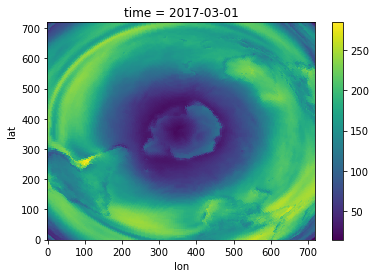

In [39]:
CACK_EASE2S_full_xr.sel(time='2017-03-01').plot()

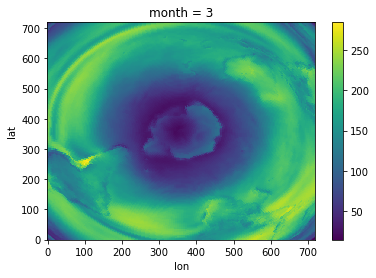

In [35]:
CACK_climatology_year_SH.sel(month=3).plot()

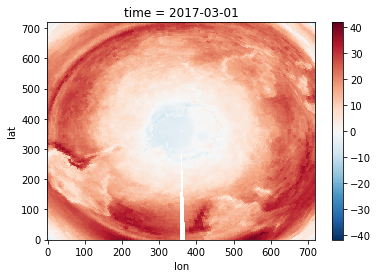

In [36]:
CACK_UNCERT_EASE2S_full_xr.sel(time='2017-03-01').plot()

In [37]:
CACK_EASE2N_full_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_extended_climatology_bf_fill_NH.nc')
CACK_EASE2S_full_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_extended_climatology_bf_fill_SH.nc')

CACK_UNCERT_EASE2N_full_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_UNCERT_extended_climatology_bf_fill_NH.nc')
CACK_UNCERT_EASE2S_full_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_UNCERT_extended_climatology_bf_fill_SH.nc')

In [ ]:
CACK_EASE2N_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_NH.nc')
CACK_EASE2S_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_SH.nc')

CACK_UNCERT_EASE2N_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_UNCERT_NH.nc')
CACK_UNCERT_EASE2S_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_UNCERT_SH.nc')

<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 144, plev: 17, time: 12)
Coordinates:
  * longitude  (longitude) float64 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * latitude   (latitude) float64 79.0 77.0 75.0 73.0 ... -75.0 -77.0 -79.0
  * plev       (plev) float64 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * time       (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    lw_t       (time, plev, latitude, longitude) float64 ...
    lwclr_t    (time, plev, latitude, longitude) float64 ...
    lw_q       (time, plev, latitude, longitude) float64 ...
    lwclr_q    (time, plev, latitude, longitude) float64 ...
    sw_q       (time, plev, latitude, longitude) float64 ...
    swclr_q    (time, plev, latitude, longitude) float64 ...
    lw_ts      (time, latitude, longitude) float64 ...
    lwclr_ts   (time, latitude, longitude) float64 ...
    sw_a       (time, latitude, longitude) float64 ...
    swclr_a    (time, latitude, longitude) fl

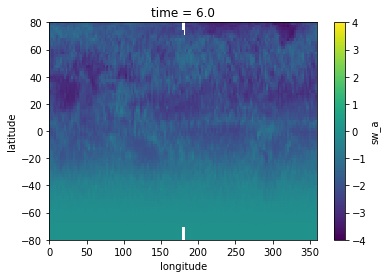

In [56]:
#CS radiative forcing kernels to EASE2
CC_kernel = xr.open_dataset(datadriveletter+'/radiative_kernels/TOA_CS/TOA_CloudSat_Kerns.nc')
print(CC_kernel)
CC_albedo_kernel = CC_kernel['sw_a']
CC_albedo_kernel[5,:,:].plot(vmin=-4, vmax=4)

CC_lon, CC_lat = np.meshgrid(pyresample.utils.wrap_longitudes(CC_albedo_kernel.longitude.values), CC_albedo_kernel.latitude.values)
CC_swath = pyresample.geometry.SwathDefinition(lats=np.squeeze(CC_lat), lons=CC_lon)
EASE2N_swath = pyresample.geometry.SwathDefinition(lats=EASE2Nlat, lons=EASE2Nlon)
EASE2S_swath = pyresample.geometry.SwathDefinition(lats=EASE2Slat, lons=EASE2Slon)

(EASE2N_valid_input_index, EASE2N_valid_output_index, \
 EASE2N_index_array, EASE2N_distance_array) = pyresample.kd_tree.get_neighbour_info(CC_swath, EASE2N_swath, \
                                                                      radius_of_influence=175000, \
                                                                      neighbours=1, nprocs=8)

(EASE2S_valid_input_index, EASE2S_valid_output_index, \
 EASE2S_index_array, EASE2S_distance_array) = pyresample.kd_tree.get_neighbour_info(CC_swath, EASE2S_swath, \
                                                                      radius_of_influence=175000, \
                                                                      neighbours=1, nprocs=8)

In [68]:
from dask.diagnostics import ProgressBar
from tqdm.notebook import trange, tqdm

res = []
#width_nh = height_nh = 720
for i in tqdm(range(len(CC_albedo_kernel.time.values))):
    res.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_nh,height_nh), \
                                                                CC_albedo_kernel.values[i,:,:], EASE2N_valid_input_index, \
                                                                 EASE2N_valid_output_index, EASE2N_index_array, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
with ProgressBar():
    res = da.stack(res).compute()
CC_ALB_KERNEL_EASE2_NH_xr = xr.DataArray(data=res, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':CC_albedo_kernel.time.values})

res = []
#width_sh = height_sh = 720
for i in tqdm(range(len(CC_albedo_kernel.time.values))):
    res.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_sh,height_sh), \
                                                                CC_albedo_kernel.values[i,:,:], EASE2S_valid_input_index, \
                                                                 EASE2S_valid_output_index, EASE2S_index_array, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
with ProgressBar():
    res = da.stack(res).compute()
CC_ALB_KERNEL_EASE2_SH_xr = xr.DataArray(data=res, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':CC_albedo_kernel.time.values})


[########################################] | 100% Completed |  0.1s



[########################################] | 100% Completed |  0.1s


In [69]:
#Now fill in the near-pole gap with a mean from the surroundings
for mn in np.arange(1,13):
    #mn = np.float(mn)
    fillval = CC_ALB_KERNEL_EASE2_NH_xr.where(CC_ALB_KERNEL_EASE2_NH_xr.time==mn).where(CC_ALB_KERNEL_EASE2_NH_xr.latitude>75).mean()
    print(mn,fillval)
    CC_ALB_KERNEL_EASE2_NH_xr[mn-1,:,:] = \
        xr.where(CC_ALB_KERNEL_EASE2_NH_xr[mn-1,:,:].latitude>80, fillval, CC_ALB_KERNEL_EASE2_NH_xr[mn-1,:,:])
    CC_ALB_KERNEL_EASE2_NH_xr[mn-1,:,:] = \
        xr.where((CC_ALB_KERNEL_EASE2_NH_xr[mn-1,:,:].latitude>60) & (np.isnan(CC_ALB_KERNEL_EASE2_NH_xr[mn-1,:,:])), fillval, CC_ALB_KERNEL_EASE2_NH_xr[mn-1,:,:])

for mn in np.arange(1,13):
    #mn = np.float(mn)
    fillval = CC_ALB_KERNEL_EASE2_SH_xr.where(CC_ALB_KERNEL_EASE2_SH_xr.time==mn).where(CC_ALB_KERNEL_EASE2_SH_xr.latitude<-75).mean()
    print(mn,fillval)
    CC_ALB_KERNEL_EASE2_SH_xr[mn-1,:,:] = \
        xr.where(CC_ALB_KERNEL_EASE2_SH_xr[mn-1,:,:].latitude<-80, fillval, CC_ALB_KERNEL_EASE2_SH_xr[mn-1,:,:])
    CC_ALB_KERNEL_EASE2_SH_xr[mn-1,:,:] = \
        xr.where((CC_ALB_KERNEL_EASE2_SH_xr[mn-1,:,:].latitude<-60) & (np.isnan(CC_ALB_KERNEL_EASE2_SH_xr[mn-1,:,:])), fillval, CC_ALB_KERNEL_EASE2_SH_xr[mn-1,:,:])

1 <xarray.DataArray ()>
array(0.)
2 <xarray.DataArray ()>
array(-0.00253197)
3 <xarray.DataArray ()>
array(-0.53709998)
4 <xarray.DataArray ()>
array(-1.41079156)
5 <xarray.DataArray ()>
array(-2.10671135)
6 <xarray.DataArray ()>
array(-2.32367703)
7 <xarray.DataArray ()>
array(-2.10624526)
8 <xarray.DataArray ()>
array(-1.21966332)
9 <xarray.DataArray ()>
array(-0.41607191)
10 <xarray.DataArray ()>
array(-0.05962569)
11 <xarray.DataArray ()>
array(-4.85877687e-05)
12 <xarray.DataArray ()>
array(-6.0164792e-06)
1 <xarray.DataArray ()>
array(-3.35099979)
2 <xarray.DataArray ()>
array(-2.19263753)
3 <xarray.DataArray ()>
array(-0.58343893)
4 <xarray.DataArray ()>
array(-0.07268387)
5 <xarray.DataArray ()>
array(-4.91593178e-05)
6 <xarray.DataArray ()>
array(0.)
7 <xarray.DataArray ()>
array(0.)
8 <xarray.DataArray ()>
array(-0.01174436)
9 <xarray.DataArray ()>
array(-0.49062199)
10 <xarray.DataArray ()>
array(-1.59553829)
11 <xarray.DataArray ()>
array(-3.02307867)
12 <xarray.DataArray (

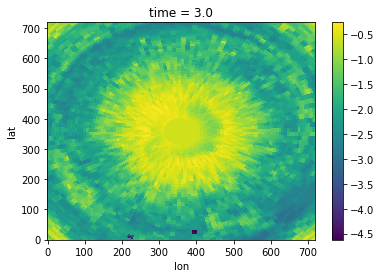

In [70]:
CC_ALB_KERNEL_EASE2_SH_xr[2,:,:].plot()

In [71]:
CC_ALB_KERNEL_EASE2_NH_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CC_NH.nc')
CC_ALB_KERNEL_EASE2_SH_xr.to_netcdf(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CC_SH.nc')

In [ ]:
# for NH snow cover data input, see NSID0046 and NSIDC0046_Snowcover_CDR_to_CLARA.ipynb

In [23]:
#construct SI cover for Antarctica
Antarctic_seaice = xr.open_mfdataset(datadriveletter+'/G02202_V3_Antarctic_seaice/*.nc', combine='by_coords')

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\conventions.py:494: SerializationWarning: variable 'melt_onset_day_seaice_conc_monthly_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  use_cftime=use_cftime,


In [42]:
Antarctic_seaice

<xarray.Dataset>
Dimensions:                                 (time: 493, xgrid: 316, ygrid: 332)
Coordinates:
    latitude                                (ygrid, xgrid) float64 dask.array<chunksize=(332, 316), meta=np.ndarray>
    longitude                               (ygrid, xgrid) float64 dask.array<chunksize=(332, 316), meta=np.ndarray>
  * xgrid                                   (xgrid) float32 -3937500.0 ... 3937500.0
  * ygrid                                   (ygrid) float32 4337500.0 ... -3937500.0
  * time                                    (time) datetime64[ns] 1978-11-01 ... 2019-12-01
Data variables:
    projection                              (time) |S1 b'' b'' b'' ... b'' b''
    seaice_conc_monthly_cdr                 (time, ygrid, xgrid) float32 dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    stdev_of_seaice_conc_monthly_cdr        (time, ygrid, xgrid) float32 dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    melt_onset_day_seaice_conc_monthly_cdr  (time, ygrid, xgrid) float32 dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    qa_of_seaice_conc_monthly_cdr           (time, ygrid, xgrid) float32 dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    goddard_merged_seaice_conc_monthly      (time, ygrid, xgrid) float32 dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    goddard_nt_seaice_conc_monthly          (time, ygrid, xgrid) float32 dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    goddard_bt_seaice_conc_monthly          (time, ygrid, xgrid) float32 dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   The variable melt_onset_day_seaice_conc_monthl...
    program:                   NOAA Climate Data Record Program
    cdr_variable:              seaice_conc_monthly_cdr
    software_version_id:       git@bitbucket.org:nsidc/seaice_cdr.git@8a56cd2...
    Metadata_Link:             https://nsidc.org/api/dataset/metadata/v2/oai?...
    product_version:           v03r01
    spatial_resolution:        25km
    standard_name_vocabulary:  CF Standard Name Table (v16, 11 October 2010)
    id:                        G02202
    naming_authority:          nsidc.org
    license:                   No constraints on data access or use
    summary:                   This data set provides a passive microwave sea...
    keywords:                  EARTH SCIENCE > CRYOSPHERE > SEA ICE > SEA ICE...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Key...
    cdm_data_type:             Grid
    project:                   NOAA/NSIDC passive microwave sea ice concentra...
    creator_url:               http://nsidc.org/
    creator_email:             nsidc@nsidc.org
    institution:               NSIDC > National Snow and Ice Data Center
    processing_level:          NOAA Level 3
    geospatial_lat_min:        -90.0
    geospatial_lat_max:        -41.45
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lon_units:      degrees_east
    time_coverage_duration:    P1M
    time_coverage_resolution:  P1M
    contributor_name:          Walt Meier, Ruth Duerr, Florence Fetterer, Jul...
    contributor_role:          PrincipalInvestigator,author,author,author,aut...
    acknowledgment:            This project was supported in part by a grant ...
    source:                    ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G0...
    history:                   seaice_conc_monthly_sh_f08_198708_v03r01.nc cr...
    platform:                  DMSP 5D-2/F8 > Defense Meteorological Satellit...
    sensor:                    SSM/I > Special Sensor Microwave/Imager
    date_created:              2019-03-05T22:36:39Z
    time_coverage_start:       1987-08-01T00

In [25]:
#reproject to EASE2
from pyproj import Proj
try:
    # Works with pyproj 2.0+
    PROJECTION_NH = Proj('EPSG:6931')
    PROJECTION_SH = Proj('EPSG:6932')
except RuntimeError:
    # Works with pyproj 1.x
    PROJECTION_NH = Proj('+init=EPSG:6931')
    PROJECTION_SH = Proj('+init=EPSG:6932')
    
# Create output grid coordinates in projection units (meters)
RESOLUTION = 25000.
WIDTH = 720
HEIGHT = 720
X_VECT = np.arange(-RESOLUTION * WIDTH / 2. + RESOLUTION / 2.,
                   RESOLUTION * WIDTH / 2., RESOLUTION)
# Orient so that 0-meridian is pointing down
Y_VECT = np.arange(RESOLUTION * WIDTH / 2. - RESOLUTION / 2.,
                   -RESOLUTION * WIDTH / 2., -RESOLUTION)
TARGET_X, TARGET_Y = np.meshgrid(X_VECT, Y_VECT)
#EASE2Nlon, EASE2Nlat = PROJECTION_NH(TARGET_X, TARGET_Y, inverse=True)
EASE2Slon, EASE2Slat = PROJECTION_SH(TARGET_X, TARGET_Y, inverse=True)

G02202_swath = pyresample.geometry.SwathDefinition(lats=np.squeeze(Antarctic_seaice.latitude.values), lons=Antarctic_seaice.longitude.values)
#EASE2N_swath = pyresample.geometry.SwathDefinition(lats=EASE2Nlat, lons=EASE2Nlon)
EASE2S_swath = pyresample.geometry.SwathDefinition(lats=EASE2Slat, lons=EASE2Slon)

#(valid_input_index_NH, valid_output_index_NH, \
# index_array_NH, distance_array_NH) = pyresample.kd_tree.get_neighbour_info(CLARA_swath, EASE2N_swath, \
#                                                                      radius_of_influence=35000, \
#                                                                      neighbours=1, nprocs=8)
(valid_input_index_SH, valid_output_index_SH, \
 index_array_SH, distance_array_SH) = pyresample.kd_tree.get_neighbour_info(G02202_swath, EASE2S_swath, \
                                                                      radius_of_influence=35000, \
                                                                      neighbours=1, nprocs=8)

In [26]:
from dask.diagnostics import ProgressBar
from tqdm.notebook import trange, tqdm

res = []
width_sh = height_sh = 720
for i in tqdm(range(len(Antarctic_seaice.time.values))):
    res.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_sh,height_sh), \
                                                                Antarctic_seaice['goddard_merged_seaice_conc_monthly'].values[i,:,:], \
                                                                 valid_input_index_SH, \
                                                                 valid_output_index_SH, index_array_SH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
with ProgressBar():
    res = da.stack(res).compute()
Antarctic_seaice_xr = xr.DataArray(data=res, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':pd.to_datetime(Antarctic_seaice.time.values)})


[########################################] | 100% Completed |  0.6s


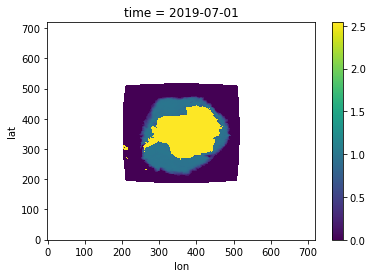

In [28]:
Antarctic_seaice_xr[-6,:,:].plot()

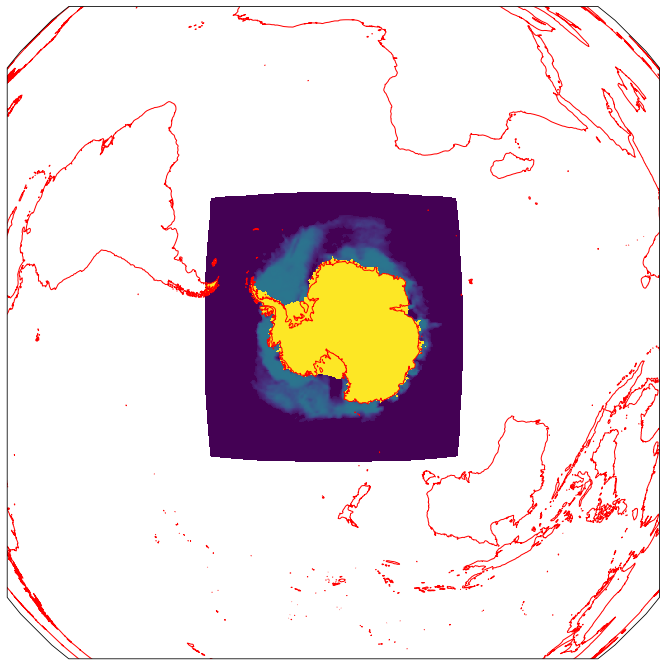

In [43]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(Antarctic_seaice_xr.longitude, Antarctic_seaice_xr.latitude,\
               Antarctic_seaice_xr.sel(time='1989-12-01').values, transform=ccrs.PlateCarree())
ax.coastlines('50m', color='r')
ax.grid()
plt.show()

In [29]:
# data gap exists for Dec87 & Jan88. Fill in w/ 10-yr climatology
Antarctic_seaice_climatology = Antarctic_seaice_xr.sel(time=slice('1982','1991')).groupby('time.month').mean()
Antarctic_seaice_dec_climatology = Antarctic_seaice_climatology.sel(month=12)
Antarctic_seaice_jan_climatology = Antarctic_seaice_climatology.sel(month=1)



C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [37]:
Antarctic_seaice_xr_filled = Antarctic_seaice_xr.resample(time='1MS').asfreq()

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


In [38]:
Antarctic_seaice_xr_filled.loc[dict(time='1987-12')] = Antarctic_seaice_dec_climatology.values
Antarctic_seaice_xr_filled.loc[dict(time='1988-01')] = Antarctic_seaice_jan_climatology.values

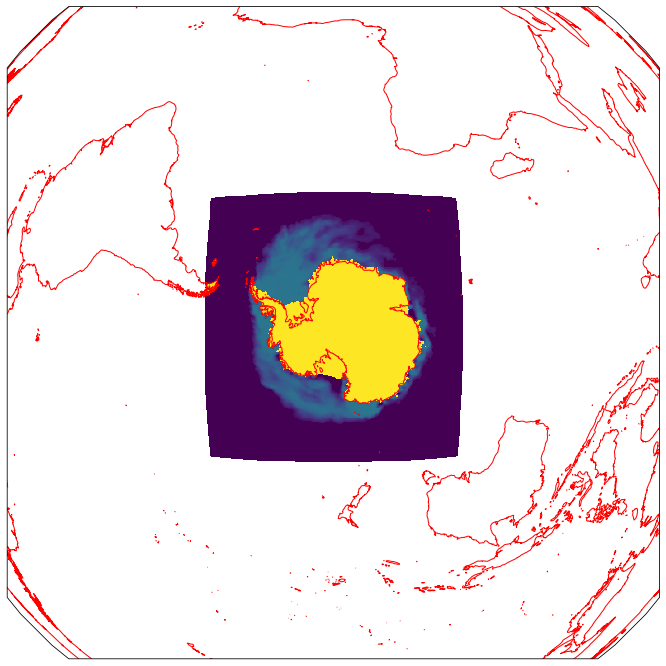

In [45]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(Antarctic_seaice_xr.longitude, Antarctic_seaice_xr.latitude,\
               Antarctic_seaice_xr.sel(time='2015-12-01').values, transform=ccrs.PlateCarree())
ax.coastlines('50m', color='r')
ax.grid()
plt.show()

In [46]:
Antarctic_seaice_xr_filled

<xarray.DataArray (time: 494, lat: 720, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2019-12-01
    latitude   (lat, lon) float64 81.94 79.95 78.29 76.84 ... 78.29 79.95 81.94
    longitude  (lat, lon) float64 -45.0 -44.92 -44.84 ... 135.2 135.1 135.0
Dimensions without coordinates: lat, lon

In [47]:
Antarctic_seaice_xr_filled.to_netcdf(datadriveletter+'/radiative_forcing_2020/production_data/G02202_Antarctic_seaice_full_1978_2018_v2.nc')

In [43]:
#prep wind speed data for OSA (WSA) calculation
winds = glob.glob(datadriveletter+'/windspeed/Wind_speed_????????')
wlat = np.arange(89.75, -90, -0.25)
print(wlat.shape)

wlon = np.arange(-0.125, 360-0.25, 0.25)
print(wlon.shape)
wlong, wlatg = np.meshgrid(wlon, wlat)
wlong = pyresample.utils.wrap_longitudes(wlong)

(719,)
(1440,)


In [49]:
wind_swath = pyresample.geometry.SwathDefinition(lats=wlatg, lons=wlong)

(valid_input_index_NH, valid_output_index_NH, \
 index_array_NH, distance_array_NH) = pyresample.kd_tree.get_neighbour_info(wind_swath, EASE2N_swath, \
                                                                      radius_of_influence=35000, \
                                                                      neighbours=1, nprocs=8)
(valid_input_index_SH, valid_output_index_SH, \
 index_array_SH, distance_array_SH) = pyresample.kd_tree.get_neighbour_info(wind_swath, EASE2S_swath, \
                                                                      radius_of_influence=35000, \
                                                                      neighbours=1, nprocs=8)

In [50]:
from dask.diagnostics import ProgressBar
from tqdm.notebook import trange, tqdm
import pandas as pd

res = []
times = []
width_nh = height_nh = 720
for i in tqdm(range(len(winds))):
    thistime = pd.to_datetime(winds[i].split('_')[-1], format='%Y%m%d')
    thiswind = np.reshape(np.fromfile(winds[i], dtype=np.float32), (719,1440))
    res.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_nh,height_nh), \
                                                                thiswind, valid_input_index_NH, \
                                                                 valid_output_index_NH, index_array_NH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    times.append(thistime)
with ProgressBar():
    res = da.stack(res).compute()
WINDSPEED_EASE2_NH = xr.DataArray(data=res, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Nlat),\
                                 'longitude':(('lat','lon'),EASE2Nlon),\
                                 'time':times})


[########################################] | 100% Completed |  1.6s


In [51]:
res = []
times = []
width_sh = height_sh = 720
for i in tqdm(range(len(winds))):
    thistime = pd.to_datetime(winds[i].split('_')[-1], format='%Y%m%d')
    thiswind = np.reshape(np.fromfile(winds[i], dtype=np.float32), (719,1440))
    res.append(pyresample.kd_tree.get_sample_from_neighbour_info('nn', (width_sh,height_sh), \
                                                                thiswind, valid_input_index_SH, \
                                                                 valid_output_index_SH, index_array_SH, \
                                                                 weight_funcs=None, \
                                                                 fill_value=np.nan, with_uncert=False))
    times.append(thistime)
with ProgressBar():
    res = da.stack(res).compute()
WINDSPEED_EASE2_SH = xr.DataArray(data=res, dims=('time', 'lat', 'lon'), \
                          coords={'latitude':(('lat','lon'),EASE2Slat),\
                                 'longitude':(('lat','lon'),EASE2Slon),\
                                 'time':times})


[########################################] | 100% Completed |  1.5s


In [54]:
WINDSPEED_EASE2_NH_MM = WINDSPEED_EASE2_NH.sortby('time').resample(time='MS').mean()
WINDSPEED_EASE2_SH_MM = WINDSPEED_EASE2_SH.sortby('time').resample(time='MS').mean()

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


In [71]:
WINDSPEED_EASE2_NH_MM.to_netcdf(datadriveletter+'/radiative_forcing_2020/production_data/Windspeeds_EASE2_NH_1979_2019.nc')
WINDSPEED_EASE2_SH_MM.to_netcdf(datadriveletter+'/radiative_forcing_2020/production_data/Windspeeds_EASE2_SH_1979_2019.nc')

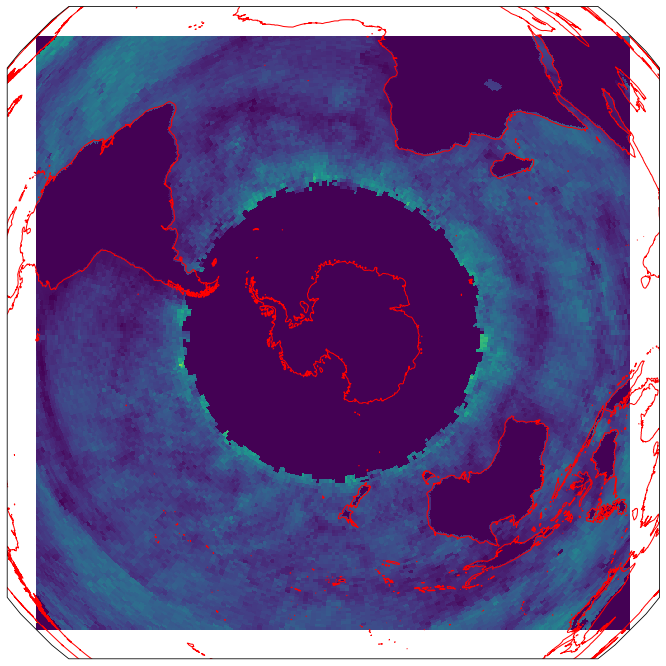

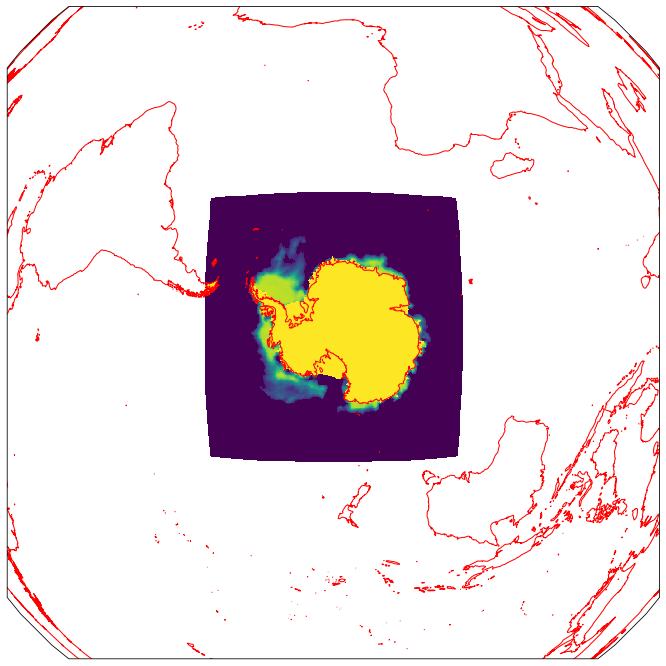

In [87]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(WINDSPEED_EASE2_SH_MM.longitude, WINDSPEED_EASE2_SH_MM.latitude,\
               WINDSPEED_EASE2_SH_MM.sel(time='1984-01-01').values, transform=ccrs.PlateCarree())
ax.coastlines('50m', color='r')
ax.grid()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(Antarctic_seaice_xr_filled.longitude, Antarctic_seaice_xr_filled.latitude,\
               Antarctic_seaice_xr_filled.sel(time='1984-01-01').values, transform=ccrs.PlateCarree(), vmax=1.10)
ax.coastlines('50m', color='r')
ax.grid()
plt.show()

In [118]:
# gaps remain in early wind speed coverage. Need to fill with climatological (month-specific) mean 
# in want of other sources
WINDSPEED_CLIMATOLOGICAL_SH = WINDSPEED_EASE2_SH_MM.groupby(WINDSPEED_EASE2_SH_MM.time.dt.month).mean()
WINDSPEED_CLIMATOLOGICAL_NH = WINDSPEED_EASE2_NH_MM.groupby(WINDSPEED_EASE2_NH_MM.time.dt.month).mean()


C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


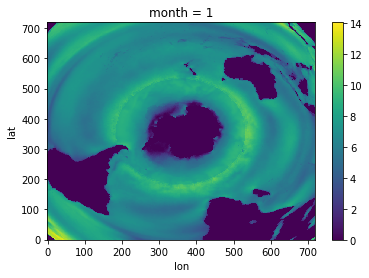

In [119]:
WINDSPEED_CLIMATOLOGICAL_SH[0,:,:].plot()

In [125]:
WINDSPEED_EASE2_SH_MM_GF=xr.where(WINDSPEED_EASE2_SH_MM==0, 
                                               WINDSPEED_CLIMATOLOGICAL_SH.sel(month=WINDSPEED_EASE2_SH_MM.time.dt.month), 
                                               WINDSPEED_EASE2_SH_MM)
WINDSPEED_EASE2_NH_MM_GF=xr.where(WINDSPEED_EASE2_NH_MM==0, 
                                               WINDSPEED_CLIMATOLOGICAL_NH.sel(month=WINDSPEED_EASE2_NH_MM.time.dt.month), 
                                               WINDSPEED_EASE2_NH_MM)

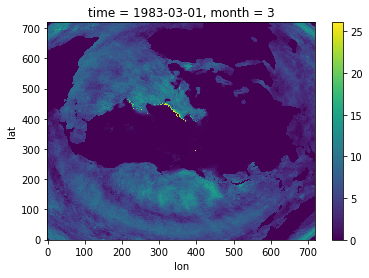

In [126]:
WINDSPEED_EASE2_NH_MM_GF[50,:,:].plot()

In [124]:
WINDSPEED_EASE2_NH_MM_GF.to_netcdf(datadriveletter+'/radiative_forcing_2020/production_data/Windspeeds_EASE2_NH_1979_2019_gapfilled.nc')
WINDSPEED_EASE2_SH_MM_GF.to_netcdf(datadriveletter+'/radiative_forcing_2020/production_data/Windspeeds_EASE2_SH_1979_2019_gapfilled.nc')

In [127]:
#now insert water diffuse OSA after https://www.geosci-model-dev.net/11/321/2018/gmd-11-321-2018.pdf
osa_dif = 0.064
osa_wc = 0.174

WINDSPEED_EASE2_NH_MM_GF = xr.where(WINDSPEED_EASE2_NH_MM_GF<50, WINDSPEED_EASE2_NH_MM_GF, np.nan)
WINDSPEED_EASE2_NH_MM_GF = xr.where(WINDSPEED_EASE2_NH_MM_GF>0, WINDSPEED_EASE2_NH_MM_GF, np.nan)

WINDSPEED_EASE2_SH_MM_GF = xr.where(WINDSPEED_EASE2_SH_MM_GF<50, WINDSPEED_EASE2_SH_MM_GF, np.nan)
WINDSPEED_EASE2_SH_MM_GF = xr.where(WINDSPEED_EASE2_SH_MM_GF>0, WINDSPEED_EASE2_SH_MM_GF, np.nan)

foam_fract_NH = ( 2.95e-6 ) * pow( WINDSPEED_EASE2_NH_MM_GF, 3.52 )
foam_fract_SH = ( 2.95e-6 ) * pow( WINDSPEED_EASE2_SH_MM_GF, 3.52 )

OSA_NH = (1.0-foam_fract_NH) * osa_dif + foam_fract_NH * osa_wc
OSA_NH = OSA_NH.where(OSA_NH<1.0, np.nan)

OSA_SH = (1.0-foam_fract_SH) * osa_dif + foam_fract_SH * osa_wc
OSA_SH = OSA_SH.where(OSA_SH<1.0, np.nan)

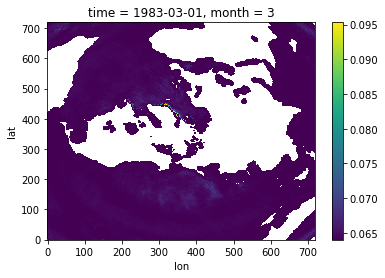

In [128]:
OSA_NH[50,:,:].plot()

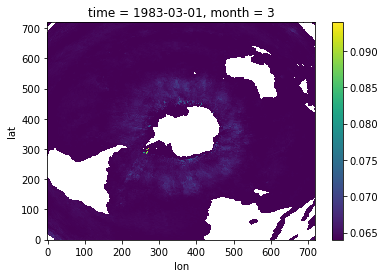

In [129]:
OSA_SH[50,:,:].plot()

In [130]:
OSA_NH.to_netcdf(datadriveletter+'/radiative_forcing_2020/production_data/OSA_EASE2_NH_1979_2019_gapfilled.nc')
OSA_SH.to_netcdf(datadriveletter+'/radiative_forcing_2020/production_data/OSA_EASE2_SH_1979_2019_gapfilled.nc')
